In [1]:
import tensorflow as tf
import pickle
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

import pandas as pd

In [2]:
import math

import seaborn as sns

# charge prediction
 - find threshold

In [3]:
def reshapeOneHot(X):
    X = np.dstack(X)
    X = np.swapaxes(X, 1, 2)
    X = np.swapaxes(X, 0, 1)
    return X

def one_hot_encode_peptide(peptide, MAX_LENGTH = 41):
    if len(peptide) > MAX_LENGTH:
        print('Peptide length is larger than maximal length of ', str(MAX_LENGTH))
        return None
    else:
        AA_vocabulary = 'KRPTNAQVSGILCMJHFYWEDBXO'#B: acetyl; O: Carbamyl; J: oxidized Met; X:pyro_glu
        no_not_used_aas = 1#U: not used

        one_hot_peptide = np.zeros((len(peptide), len(AA_vocabulary) - no_not_used_aas))

        for j in range(0, len(peptide)):
            try:
                aa = peptide[j]
                one_hot_peptide[j, AA_vocabulary.index(aa)] = 1
            except:
                pass
        
        no_front_paddings = int((MAX_LENGTH - len(peptide))/2)
        peptide_front_paddings = np.zeros((no_front_paddings, one_hot_peptide.shape[1]))

        no_back_paddings = MAX_LENGTH - len(peptide) - no_front_paddings
        peptide_back_paddings = np.zeros((no_back_paddings, one_hot_peptide.shape[1]))

        full_one_hot_peptide = np.vstack((peptide_front_paddings, one_hot_peptide, peptide_back_paddings))

        return peptide, full_one_hot_peptide
    
AA_vocabulary = 'KRPTNAQVSGILCMJHFYWEDBXOU'#B: acetyl; J: oxidized Met; X:pyro_glu
single2psi_lookup = {'B': '(Acetyl)-',
                     'J': 'M(Oxidation)',
                     'X': '(Gln->pyro-Glu)Q',
                     'C': 'C(Carbamidomethyl)'}

def one_hot_to_single_ptm(one_hot):
    seq = ''
    for row in one_hot:
        if row.sum() > 0:
            idx = row.argmax()
            seq += AA_vocabulary[idx]
    return seq



def single_ptm_to_psi(single_ptm_seq):
    psi_seq = single_ptm_seq
    for code in single2psi_lookup:
        psi_seq = psi_seq.replace(code, single2psi_lookup[code])
    return psi_seq

fn1 = '../refModel/2019MCP_Guan/LCMSMS_Pred_Supplemental_Material_section_S6/ChargeState/zfit_bidirLSTM2_masking_result.pickle'
with open(fn1, 'rb') as fid:
    pred_data = pickle.load(fid)

fn2 = '../refModel/2019MCP_Guan/LCMSMS_Pred_Supplemental_Material_section_S6/ChargeState/zfit_one_hot.pickle'
with open(fn2, 'rb') as fid:
    real_data = pickle.load(fid)

def plot_zfit(train_X, train_y, predicted_train_y, n):

    X = train_X[n]
    s_seq = one_hot_to_single_ptm(X)
    print(s_seq)
    psi_seq = single_ptm_to_psi(s_seq)
    print(psi_seq)
   
    y_exp = train_y[n]
    y_pred = predicted_train_y[n]
    pcc = pearsonr(y_exp, y_pred)

    fig, ax = plt.subplots()
    charges = range(1, len(y_exp) + 1)
    ax.stem(charges, y_exp, 'b', markerfmt=" ", label='Experimental')
    ax.stem(charges, -y_pred, 'g', markerfmt=" ", label='Predicted')
    plt.text(1.5, -0.35, 'pcc: %6.3f, %6.3g'%(pcc[0], pcc[1]))
    plt.xticks(charges)
    plt.xlabel('charge')
    plt.title(psi_seq)
    plt.show()

In [4]:
network_ori = tf.keras.models.load_model('../refModel/2019MCP_Guan/LCMSMS_Pred_Supplemental_Material_section_S6/ChargeState/zfit_bidirLSTM2_masking_model.h5')

print(network_ori.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 23)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         573440    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 2,280,965
Trainable params: 2,280,965
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
train = pd.read_csv('../data/df_detect_peptide_train.csv')
test = pd.read_csv('../data/df_detect_peptide_test.csv')

df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [8]:
ided_pep = df.loc[df.ID==1].PEP.unique()
whole_pep = df.PEP.unique()

In [9]:
df.shape, len(df.PEP.unique()), len(ided_pep)

((813388, 8), 797400, 394700)

# Search Threshold
 - 몇 이상의 값을 가진 charge를 사용할 것인가, 나머지는 zero padding 해야한다.

In [10]:
df_kb = pd.read_csv('../data/massIVE-KB/df_kb_strip.csv')
df_uni = pd.read_csv('../data/uniprot/df_uni_ided.csv')

df_kb_not6charge = df_kb.loc[df_kb.CHARGE!=6].reset_index(drop=True)

pep2charge = dict()
for p, c in df_kb_not6charge[['PEPTIDE', 'CHARGE']].values:
    if p not in pep2charge:
        pep2charge[p] = [0, 0, 0, 0, 0]
    pep2charge[p][int(c)-1] += 1

ided_pep2charge = dict()
for p in ided_pep:
    try:
        ided_pep2charge[p] = pep2charge[p]
    except:
        pass  # charge 6 case

In [11]:
kb_y = np.array(list(ided_pep2charge.values()))
kb_X_str = np.array(list(ided_pep2charge.keys()))

In [12]:
ided_pep2onehot = dict()
for p in kb_X_str:
    o = one_hot_encode_peptide(p)
    ided_pep2onehot[p] = o[1]
kb_X = np.array(list(ided_pep2onehot.values()))
print(kb_X.shape)

(394661, 41, 23)


In [29]:
test=kb_X[:1000]
kb_pred = network_ori.predict(test)

In [31]:
print(round(16.4*(394661/1000)/3600, 2), 'hour estimated')

1.8 hour estimated


In [14]:
kb_pred = network_ori.predict(kb_X)

In [15]:
kb_pred_log = np.array([np.array(list(map(lambda x: -math.log(x), _))) for _ in kb_pred])

FSPEAFTEQLYR
FSPEAFTEQLYR


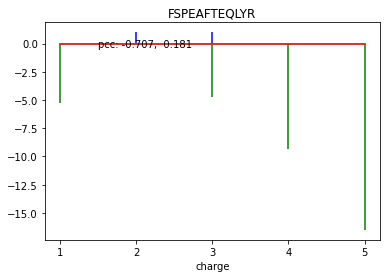

In [16]:
plot_zfit(kb_X, kb_y, kb_pred_log, 9)

In [17]:
pred_logs = []
for real, pred in zip(kb_y, kb_pred_log):
    idxes = np.where(real==1)[0]
    pred_logs += list(pred[idxes])

/home/bis/miniconda3/envs/bis/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


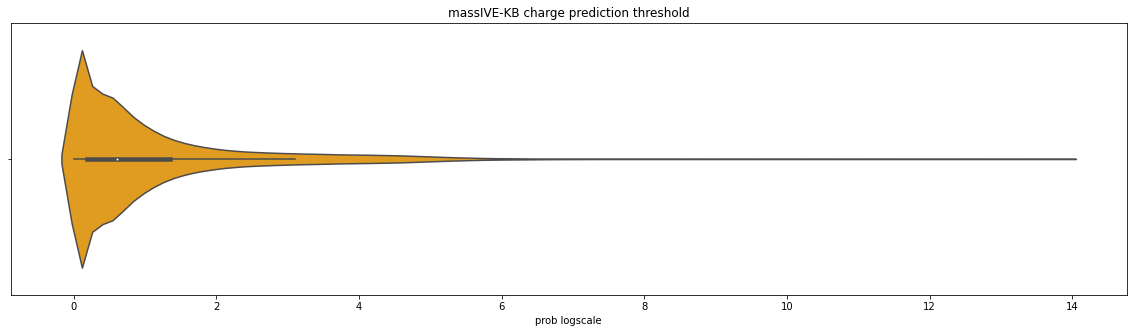

In [18]:
plt.figure(figsize=(20,5))
sns.violinplot(pred_logs, color='orange')
plt.title('massIVE-KB charge prediction threshold')
plt.xlabel('prob logscale')
plt.show()

In [19]:
print('[only real charge] below 6 ratio : ', len(list(filter(lambda x: x<=6, pred_logs)))/len(pred_logs))

[only real charge] below 6 ratio :  0.9941051614144629


In [20]:
all_logs = [__ for _ in kb_pred_log for __ in _]
print('[all charge] below 6 ratio : ', len(list(filter(lambda x: x<=6, all_logs)))/len(all_logs))

[all charge] below 6 ratio :  0.5822424815221164
